In [3]:
#=======================================
# Import modules
#=======================================

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

#=======================================
# Physical input data
#=======================================
                                         
L    = 10.0                                # Channel lenght. 
H    = 10.0                                # Channel height. 
rho  = 1.225                               # Air density at sea level in kg/m^3. Incompresible = constant density at all mesh points.
T_in = 298.0                               # Normal air temperature in K.
P_in = 1.013E05                            # Air pressure at sea level in N/m^2.
V_in = 0.15                                # Air velocity in m/s.
R    = 8.31                                # Ideal gas constant in J/mol*K

#=======================================
# Numerical input data
#=======================================

N         = 81                              # Control volumes in x direction. Odd number!
M         = 81                             # Control volumes in y direction. Odd number!
delta_X   = L / N                          # Control volume lenght in x direction.
delta_Y   = H / M                          # Control volume height in y direction.
eps       = 1.0E-06                        # Gauss-Seidel method convergence parameter.
psi_B     = 0.0                            # Stream function at the bottom of the channel.
psi_T     = V_in * H                       # Stream function at the top of the channel.
psi_s     = (psi_B + psi_T) / 2.0          # Stream function start value.
t_max     = 1000000                        # G-S loop steps.
psi_body  = psi_T / 2.0                    # Stream function inside the body

# Mesh generation

x_cv = np.linspace(0, L, N+1)              # Generate x points with the same spacing
y_cv = np.linspace(0, H, M+1)              # Generate y points with the same spacing
x_p  = np.zeros(N+2)                       # Vectors for the centered control volumes with N+2 elements
y_p  = np.zeros(M+2)                       # Vectors for the centered control volumes with M+2 elements

# Fill x_p and y_p

for i in range(1, N+1):
    x_p[i] = (x_cv[i] + x_cv[i-1]) / 2.0

for j in range(1, M+1):
    y_p[j] = (y_cv[j] + y_cv[j-1]) / 2.0

# Set boundary points at the ends of the domain
x_p[0]  = x_cv[0]                         # Left boundary
x_p[-1] = x_cv[-1]                        # Right boundary
y_p[0]  = y_cv[0]                         # Bottom boundary
y_p[-1] = y_cv[-1]                        # Top boundary

#=======================================
# Define the cylinder
#=======================================

# Cylinder definition for the plot

D = 4.0                                  # Diameter
x0 = L / 2.0                             # X position of the center of the cylinder
y0 = H / 2.0                             # Y position of the center of the cylinder

# Cylinder definition

points = 100
X = np.linspace (-D / 2.0, D / 2.0, points)
Y = np.zeros(points)
for i in range(points):
    Y[ i ] = np.sqrt((D / 2.0)**2 - X[ i ] ** 2)
    
#=======================================
# Define matrixes
#=======================================

psi       = np.zeros((N+2,M+2))           # Stream function matrix
psi_start = np.zeros((N+2,M+2))           # Start stream function
psi_ax    = np.zeros((N,M))               # Auxiliary matrix for G-S solver
rho       = np.zeros((N+2,M+2))           # Density matrix
a_P       = np.zeros((N+2,M+2))           # Auxiliar matrix at point p 
a_E       = np.zeros((N+2,M+2))           # Auxiliar matrix at point east 
a_S       = np.zeros((N+2,M+2))           # Auxiliar matrix at point south 
a_W       = np.zeros((N+2,M+2))           # Auxiliar matrix at point west 
a_N       = np.zeros((N+2,M+2))           # Auxiliar matrix at point north
b_P       = np.zeros((N+2,M+2))           # Generation term
conver    = np.zeros((N+2,M+2))           # Matrix that will be used in G-S algorithm to observe the convergence
I_body    = np.zeros((N+2,M+2))           # Solid or fluid indentificator matrix

#=======================================
# Compute I_body matrix
#=======================================

for i in range(N+2):
    for j in range(M+2):
        x_aux = x_p[i]                                         # Compute the p cell x position
        y_aux = y_p[j]                                         # Compute the p cell y position
        distance = np.sqrt((x_aux - x0)**2 + (y_aux - y0)**2)  # Compute the p cell r position
        if distance <= (D / 2.0):  # Is the r vector inside the cylinder?
            I_body[i,j] = 1        # yes ==> I_body = 1
        else:
            I_body[i,j] = 0        # no ==> I_body = 0

#=======================================
# Initialize stream function and
# density matrixes
#=======================================
rho_in = P_in / R * T_in
for i in range(N+2):
    for j in range(M+2):
        psi[i,j]       = psi_s
        psi_start[i,j] = psi_s
        rho[i,j]       = rho_in

#=======================================
# Evaluate internal nodes
#=======================================

rho_ref = rho_in                         # Set the reference value as the input (rho_ref/rho=1)
for i in range(1,N+1):
    for j in range(1,M+1):
        a_E[i,j] = (rho_ref / rho[i + 1,j]) * (delta_Y / np.abs(x_p[i] - x_p[i + 1]))
        a_W[i,j] = (rho_ref / rho[i - 1,j]) * (delta_Y / np.abs(x_p[i] - x_p[i - 1]))
        a_N[i,j] = (rho_ref / rho[i,j + 1]) * (delta_X / np.abs(y_p[j] - y_p[j + 1]))
        a_S[i,j] = (rho_ref / rho[i,j - 1]) * (delta_X / np.abs(y_p[j] - y_p[j - 1]))
        a_P[i,j] = a_E[i,j] + a_W[i,j] + a_N[i,j] + a_S[i,j]

for i in range(N+2):
    for j in range(M+2):
        psi[0,j]  = 0.0                  # Bottom nodes
        psi[-1,j] = V_in * H             # Top nodes
for i in range(N+2):
    for j in range(M+2):
        a_E[0,j]  = 0.0                  # Bottom nodes
        a_W[0,j]  = 0.0                  # Bottom nodes
        a_N[0,j]  = 0.0                  # Bottom nodes
        a_S[0,j]  = 0.0                  # Bottom nodes
        a_P[0,j]  = 1.0                  # Bottom nodes
        b_P[0,j]  = psi_B                # Bottom nodes
        a_E[-1,j] = 0.0                  # Top nodes
        a_W[-1,j] = 0.0                  # Top nodes
        a_N[-1,j] = 0.0                  # Top nodes
        a_S[-1,j] = 0.0                  # Top nodes
        a_P[-1,j] = 1.0                  # Top nodes
        b_P[-1,j] = psi_T                # Top nodes

#=======================================
# Inlet Flow
#=======================================

for j in range(1, M+1):
    psi[j,0] = V_in * y_p[j]
    b_P[j,0] = V_in * y_p[j]
    a_P[j,0] = 1.0
#=======================================
# Here we start the G-S algorithm
# loop since the outlet of psi must 
# be also solved interatively, so that
# the stream function converge.
#=======================================

psi_ax = psi                             # Set the initial value of the axuliary stream function
for t in range(t_max):
    #=======================================
    # Outlet Flow
    #=======================================
    for j in range(1, M+1):
        psi[j,-1] = psi[j,-2]
        a_W[j,-1] = 1.0
        a_P[j,-1] = 1.0

    #=======================================
    # Compute G-S for non boundary points
    #=======================================
    
    r = np.sum(psi_ax)                       # Sum the values of the psi auxiliary matrix
    for i in range(1, N+1):
        for j in range(1, M+1):
            if I_body[i,j] == 1:             # Is the p cell inside the body?
                psi[i,j] = psi_body          # yes, psi=psi_body
            else:                            # no, psi= G-S alsogirthm
                psi[i, j] = (a_E[i, j] * psi_ax[i + 1, j] + a_W[i, j] * psi_ax[i - 1, j] + a_N[i, j] * psi_ax[i, j + 1] + a_S[i,j] * psi_ax[i, j - 1] + b_P[i, j]) / a_P[i, j]

    sum = np.sum(psi)                        # Sum the values of psi matrix
    if np.abs(sum-r) <= eps:                 # Watch if the |psi - psi_aux| < precision
        print("=======================")
        print("G-S algorithm converged")
        print("The requiered steps has been:" +  " " + str(t)) 
        print("=======================")
        break                                # If corveges just break the main G-S loop
    else: 
        psi_ax = psi                         # If it does not converge, reset the valu of psi_aux and start again the loop

G-S algorithm converged
The requiered steps has been: 5090


 
Starting the plot
 
It might take a few seconds
Plot has been done sucesfully!
 
You should find it on: Horizontal_Cylindric_Flow.pdf


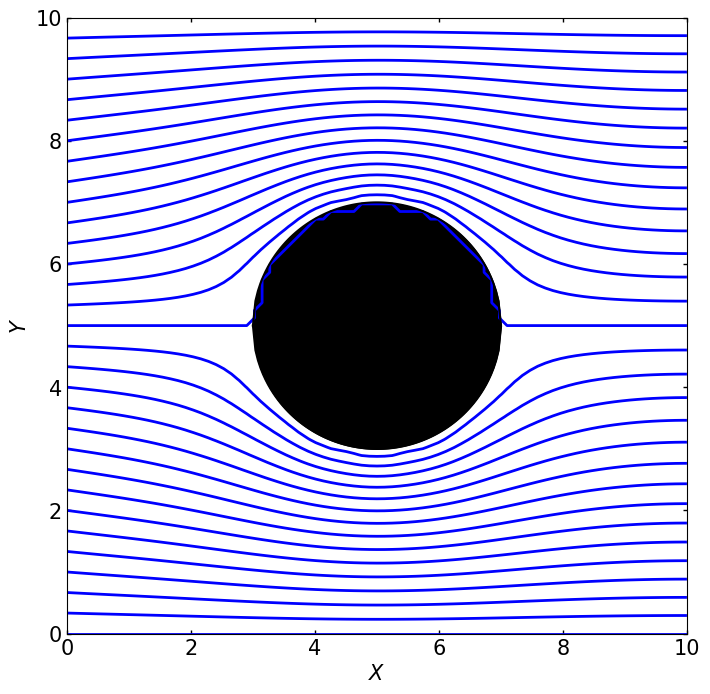

In [6]:
#=======================================
# Generate the plot
#=======================================
output_plot = "Horizontal_Cylindric_Flow.pdf"
print(" ")
print("=================")
print("Starting the plot")
print(" ")
print("It might take a few seconds")
print("===========================")

# Figure specifications
fontsize=15
plt.figure(figsize = (8,8))
plt.tick_params(axis='both', which='both',length=3, width=1.0,
labelsize=15, right=True, top=True, direction='in') # For ticks in borders

# Figure labels
plt.xlabel(r"$X$", fontsize=fontsize)
plt.ylabel(r"$Y$", fontsize=fontsize)

# Plot
plt.contour(x_p, y_p, psi, levels=30, colors='blue', linewidths=2.0)

# Cylinder plot
plt.plot(X + x0, Y + y0, color = "black")
plt.plot(X + x0,-Y + y0, color = "black")
plt.fill_between(X + x0, Y + y0, -Y + y0, color="black")

# Save figure
plt.savefig(output_plot,bbox_inches='tight')

print("Plot has been done sucesfully!")
print(" ")
print("You should find it on:" + " " + str(output_plot))
print("==============================")

plt.show();